In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import head_direction as hd
import expipe
import exdir
import os
import sys
import pathlib
import numpy as np
import numpy.ma as ma
import scipy
import tqdm

sys.path.append('../ca2-mec') if '../ca2-mec' not in sys.path else None 
import data_processing as dp

In [3]:
# change matplotlib default figsize and fonts
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize') or
        k.endswith('titlesize')
    )
})

In [4]:
# get actions
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions
# actions
list(actions.keys())

['maria-002-050721-4',
 'maria-001-280721-3',
 'maria-002-050721-1',
 'maria-137-230121-6',
 'maria-137-230121-5',
 'maria-002-050721-3',
 'maria-001-280721-5',
 'maria-001-280721-1',
 'maria-001-280721-4',
 'maria-137-230121-3',
 'maria-137-230121-4',
 'maria-001-280721-2',
 'sarah-011-120321-2',
 'maria-002-050721-2',
 'maria-137-230121-2',
 'maria-002-050721-5']

### Initialise data loader

In [5]:
# remove leading and trailing recording data
t_start = 0
t_stop = None # None => don't remove anything

max_speed = 1 # m/s only used for speed score
min_speed = 0.02 # m/s only used for speed score
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position

box_size = [1.0, 1.0]
bin_size=0.02
smoothing = 0.05

data_loader = dp.Data(
    position_sampling_rate=position_sampling_rate, 
    position_low_pass_frequency=position_low_pass_frequency,
    box_size=box_size, bin_size=bin_size, stim_mask=False, baseline_duration=None,
)

### Load data (tracking and spikes)

In [6]:
# load all tracking data (dict)trial x (dict)track_quantities x (array)time
tracking = [(action_id, data_loader.tracking(action_id)) for action_id in actions]
tracking = {action_id:track for action_id, track in tracking}

# load all spikes data (dict)trial x (dict)unit_id x spike_train
spikes = {}
for action_id in tqdm.tqdm(actions):
    spikes[action_id] = {}
    channel_grps = dp.get_channel_groups(data_loader.data_path(action_id))
    for channel_grp in channel_grps:
        # load units and "flatten" channel_grps dimension. - assuming units are unique OR duplicates across channels
        spikes[action_id].update(data_loader.spike_trains(action_id, channel_grp))

100%|██████████| 16/16 [00:19<00:00,  1.21s/it]


### Create rate maps from first and second half of trials

In [7]:
# create ratemaps from first and second half of trial
def partial_ratemap(*args, **kwargs):
    # not a general function - uses global vars etc
    (x,y),t,spike_times = dp.data_scope(*args, **kwargs)
    spatial_map = sp.SpatialMap(x,y,t,spike_times, box_size=box_size, bin_size=bin_size) # global vars
    ratemap = spatial_map.rate_map(smoothing=smoothing, mask_zero_occupancy=True) # global vars
    ratemap = np.rot90(ratemap)
    return ratemap

ratemaps = {}
for action_id in tqdm.tqdm(actions):
    ratemaps[action_id] = {}
    x,y,t,_ = tracking[action_id].values()
    for unit_id in spikes[action_id]:
        spike_times = spikes[action_id][unit_id]
        ratemaps[action_id][unit_id] = [partial_ratemap([x,y], t, spike_times, scope=np.array([0.0, 0.5])), \
                    partial_ratemap([x,y], t, spike_times, scope=np.array([0.5, 1.0]))]

100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


### (Stability) Correlate 50/50 trail-split rate maps

In [8]:
def nancorrcoef(X, Y):
    """
    Correlate X, Y (2D arrays) while ignoring nans
    """
    X = ma.masked_array(X, mask=np.isnan(X))
    Y = ma.masked_array(Y, mask=np.isnan(Y))
    return ma.corrcoef(X.flatten(), Y.flatten())[0, 1]

stability = {}
for action_id in actions:
    stability[action_id] = {}
    for unit_id in spikes[action_id]:
        stability[action_id][unit_id] = nancorrcoef(*ratemaps[action_id][unit_id])

### Group units into trials

In [9]:
trial_correlations = {}
for action_id in actions:
    trial_id = int(action_id[-1])
    if not trial_id in trial_correlations.keys():
        trial_correlations[trial_id] = []
    if 'maria' in action_id:
        trial_correlations[trial_id] += list(stability[action_id].values())

# sort dictionary on trial keys
trial_correlations = {key: value for key, value in sorted(trial_correlations.items(), key=lambda item: item[0])}

### Plot (violin) and summarise statistics (Mann-U)

T1 vs T2: MannwhitneyuResult(statistic=1990.0, pvalue=0.05493657221404444)
T1 vs T3: MannwhitneyuResult(statistic=2062.0, pvalue=0.03374047496162099)
T1 vs T4: MannwhitneyuResult(statistic=1955.0, pvalue=0.41584432175598307)
T1 vs T5: MannwhitneyuResult(statistic=2321.0, pvalue=0.010997372984844232)
T1 vs T6: MannwhitneyuResult(statistic=164.0, pvalue=0.2572778748544092)


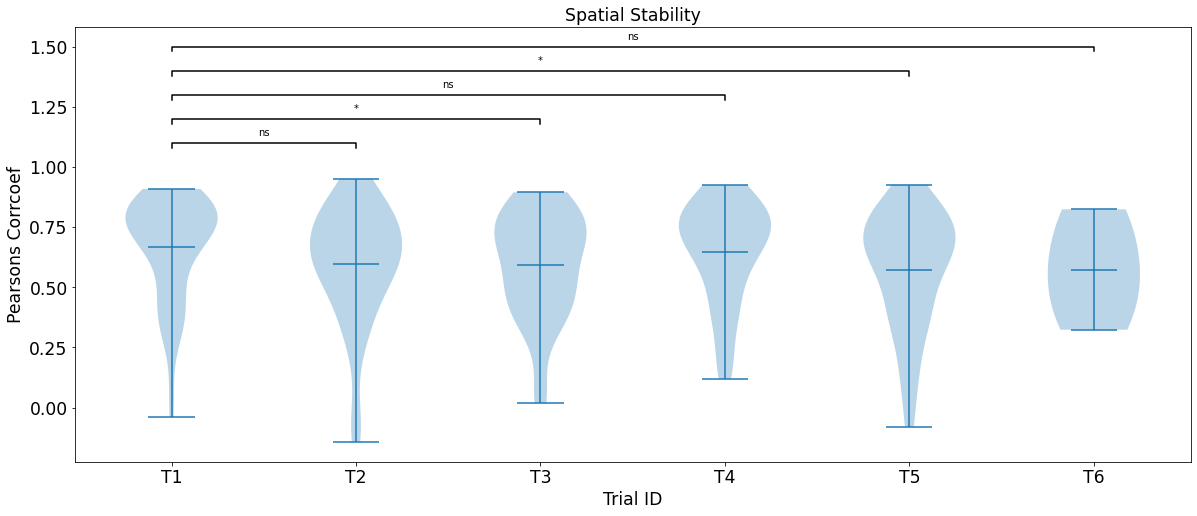

In [10]:
fig, ax = plt.subplots(figsize=(20,8))
ax.violinplot(trial_correlations.values(), showmeans=True)

# --- plot formatting ---
# add trial labels to x-axes ticks
labels = []
for trial_id in trial_correlations:
    labels.append('T' + str(trial_id))
ax.set_xticks(np.arange(1, len(labels) + 1))
ax.set_xticklabels(labels)

# set axes and title labels
ax.set_title('Spatial Stability')
ax.set_ylabel('Pearsons Corrcoef')
ax.set_xlabel('Trial ID')

def plot_significance(pvalue, x = [0, 1], y=1.2, h=0.02):
    # significance
    if pvalue < 0.0001:
        significance = "****"
    elif pvalue < 0.001:
        significance = "***"
    elif pvalue < 0.01:
        significance = "**"
    elif pvalue < 0.05:
        significance = "*"
    else:
        significance = "ns"

    x1, x2 = x
    plt.plot([x1, x1, x2, x2], [y - h, y, y, y - h], c='k')
    plt.text((x1 + x2) / 2, y + h, significance, ha='center', va='bottom')

# check sample similarities using mannwhytney (non-parametric) test
for trial_id in range(2,7):
    mw = scipy.stats.mannwhitneyu(trial_correlations[1], trial_correlations[trial_id], alternative='two-sided')
    print("T1 vs T" + str(trial_id) + ":", mw)
    plot_significance(mw.pvalue, [1,trial_id], y = 1.1 + (trial_id-2)*0.1)